# Spine Model


In [1]:
from numpy import *   #ones, cumsum, sum, isscalar
from matplotlib.pylab import * 
%matplotlib inline
plotose = True
import pickle

import PS_lib as lb
import PS_storage as st
from bootstrap import btset_cd, generateplots, btShInh


# Parameter definitions
# Data is stored here      
data = st.dataStorage() # some default parameters defined.
data.dt = 0.05
data.NMDA = False

# Definition of the model.
lb.h.dt = data.dt
NMDA = data.NMDA
model = lb.loadNeuron("Basic2.hoc",axon=False)

# Adding piece of dendritic branch with spine
model.addDend(name="DendE",locus="dendA1",L=4.0,D=1.5,ilocus=1)
model.addSpne(locus="DendE",ilocus=0.3333,L=1.0,D=1.0,Lneck=1.0,Dneck=0.15)
# Temperature of the neuron
lb.h.celsius = model.temperature
model.addDend(name="DendN",locus=3,L=240.0,D=0.5,ilocus=1)
data.model = model.__dict__

model.soma.L = 20
model.dend[-1].L = 200
model.dend[-1].diam = 10
model.addSpne(locus="DendE",ilocus=0.6666,L=1.0,D=1.0,Lneck=1.0,Dneck=0.15)

print(model.soma.L,model.soma.diam,model.soma(0.5).area(),model.dend[-1](0.5).area())

print("Topology:")
print(lb.h.topology())


	0 
	1 
	1 
	1 
	1 
20.0 29.78380012512207 1871.3713533814052 6283.185307179586
Topology:

|-|       soma(0-1)
   `|       dendA1c(0-1)
     `|       dendA1(0-1)
       `|       DendE(0-1)
         `|       DendN(0-1)
        `|       NSpne001(0-1)
          `|       Spne001(0-1)
        `|       NSpne000(0-1)
          `|       Spne000(0-1)
   `|       dendB1(0-1)

1.0


In [2]:
#with open("data_Fullset/Fullset.pkl","rb") as f:
#    data = pickle.load(f)
    
dataf = {
"inh shaft": (-2.01288, 0.606754),
"SiS": {
"Dss": (248, 1.0),
"Vh": (-2.84134 , 0.943684),
"A1": (-0.2329858,0.41,1.0),
"Ah": (-0.9274113,1.32,0.66666666667),
"Rh":  (1.92772, 0.604723),
"Rn":(4.03436, 1.00208)
},
"DiS": {
"Dss": (248, 1.0),
"Vh": (-2.0554,0.742202),
"A1": (-0.2329858,0.41,1.0),
"Ah": (-0.9274113,1.32,0.66666666667),
"Rh": (1.59667,0.436302),  
"Rn": (3.89941,1.13159),
"A2": ( -2.54262,0.531551)
},
}

### Recording places

We set recording vectors in all dendritic compartments, spine included

In [3]:
nsp = 500
dis = btset_cd(cd='DiS',size=nsp)
sis = btset_cd(cd='SiS',size=nsp)
sps = btset_cd(cd='Sp',size=nsp)

#generateplots(dis,corplot=True)

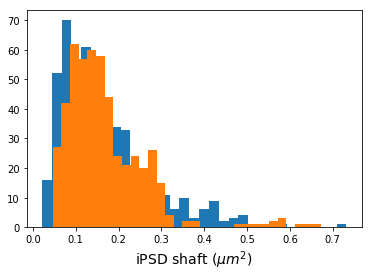

In [4]:
nsp = 500
p = dataf["inh shaft"]
iPSDsh = clip(exp(randn(nsp)*p[1]+p[0]),0,1.0)
figure()
h = hist(iPSDsh,31)
xlabel("iPSD shaft ($\mu m^2$)",fontsize=14)

iPSDsh = btShInh(size=500)
h = hist(iPSDsh,31)


In [5]:

rhGABAR = 500 # Receptors/um2
rhAMPAR = 1000 # Receptors/um2
rhNMDAR = 10 # Receptors/um2

gtrG = rhGABAR*30e-6*2/5.0
gtrA = rhAMPAR*11e-6*2/5.0
gtrN = rhNMDAR*30e-6/16.0

figureplot=False
if figureplot:
    fig, ax = subplots(nrows=1,ncols=4,figsize=(20,5))
    fig.suptitle("Number of Receptors",fontsize = 20)

    ax[0].hist(sis['A1']*rhAMPAR,31)
    ax[0].set_xlabel("#AMPAR in Sis")
    ax[1].hist(dis['A1']*rhAMPAR,31)
    ax[1].set_xlabel("#AMPAR in Dis")
    ax[2].hist(dis['A2']*rhGABAR,31)
    ax[2].set_xlabel("#GABAAR in Dis")
    ax[3].hist(iPSDsh*rhGABAR,31)
    ax[3].set_xlabel("#GABAAR in shaft")

    fig, ax = subplots(nrows=1,ncols=4,figsize=(20,5))
    fig.suptitle("Max Current",fontsize = 20)


    ax[0].hist(sis['A1']*gtrA/1e-6,31)
    ax[0].set_xlabel("I$_{max}$ (pA)")
    ax[1].hist(dis['A1']*gtrA/1e-6,31)
    ax[1].set_xlabel("I$_{max}$ (pA)")
    ax[2].hist(dis['A2']*gtrG/1e-6,31)
    ax[2].set_xlabel("I$_{max}$ (pA)")
    ax[3].hist(iPSDsh*gtrG/1e-6,31)
    ax[3].set_xlabel("I$_{max}$ (pA)")
    #savefig("D_maxI.png",bbox_inches='tight',pad_inches = 0)


In [6]:
for dend in model.dend:
    print(dend.L,dend.diam)

1.0 1.5
200.24984394500785 1.5000000000000002
50.15974481593781 1.5
4.0 1.5
200.0 10.0


In [7]:
sp0 = model.spne[0]
sp0.L = dis["L"][0]
sp0.diam = dis["D"][0]
sp1 = model.spne[1]
sp1.L = dis["L"][1]
sp1.diam = dis["D"][1]


### Excitatory synapse 

We need to define the arrival time and dynamics. These parameters may be modified later

In [8]:
lb.init_active(model, axon=False, soma=False, dend=False, dendNa=False,
                dendCa=False,spne=True)

In [9]:
model.AMPAlist = []
model.ncAMPAlist = []

tau1  = 0.5
tau2 = 3.0
nampa = 50
gmax = 15*nampa/1e6
nnmda = 2
gmaxN = 50*nnmda/1e6

AMPA0 = lb.h.Exp2Syn(1,sec = model.spne[0])
AMPA0.tau1 = tau1
AMPA0.tau2 = tau2

stimE0=lb.h.NetStim();stimE0.number = 1; 
NC0 = lb.h.NetCon(stimE0,AMPA0,0,0,gmax)
model.AMPAlist.append(AMPA0)
model.ncAMPAlist.append(NC0)
NC0.delay = 10

# NMDA part
lb.add_NMDAsyns(model, locs=[[0,0.5]], gmax=gmaxN,tau2=20.0)  
NMDA0 = model.NMDAlist[0]
NCN0 = model.ncNMDAlist[0]
stimN0=lb.h.NetStim();stimN0.number = 1;

In [10]:
NCN0 = lb.h.NetCon(stimN0,NMDA0,0,0,gmaxN)
model.ncNMDAlist[0] = NCN0
NMDA0.tau1 = 2.0
NMDA0.tau2 = 30.0

In [11]:
AMPA1 = lb.h.Exp2Syn(1,sec = model.spne[1])
AMPA1.tau1 = tau1
AMPA1.tau2 = tau2

stimE1=lb.h.NetStim();stimE1.number = 1; 
NC1 = lb.h.NetCon(stimE1,AMPA1,0,0,gmax)
model.AMPAlist.append(AMPA1)
model.ncAMPAlist.append(NC1)
NC1.delay = 10

# NMDA part
lb.add_NMDAsyns(model, locs=[[1,0.5]], gmax=gmaxN,tau2=20.0)  
NMDA1 = model.NMDAlist[0]
NCN1 = model.ncNMDAlist[0]
stimN1=lb.h.NetStim();stimN1.number = 1;


### Inhibitory synapse

In [12]:
nGABA = 35
gmaxG = nGABA*30e-6
GABA, NCG = lb.add_GABAsyns(model, locs=[[0,1]], spne=True, gmax=gmaxG,tau1=1.5,tau2=15.0)  


In [13]:
dendshaft = model.dend[-2]

nGABA = 35
gmaxG = nGABA*30e-6
GABAsh, NCGsh = lb.add_GABAsynscomp(model, dendshaft, loc = 0.3333, gmax=gmaxG,tau1=1.5,tau2=20.0)  


In [14]:
model.dend

[dendA1c, dendA1, dendB1, DendE, DendN]

In [15]:
trec, vrec = lb.h.Vector(), lb.h.Vector()
gRec, iRec,  vspneRec = [], [], []
gNMDA_rec, iNMDA_rec = [], []
trec.record(lb.h._ref_t)
vrec.record(model.soma(0.5)._ref_v)


#n=0
vDendRec = []
caDendRec = []
#For all dendrites
for dend in model.dend:
    #Adding vectors for Voltage, and Calcium
    vDendRec.append(lb.h.Vector())
    caDendRec.append(lb.h.Vector())
    # Placing recording at mid-point in the dendritic branch
    vDendRec[-1].record(dend(0.5)._ref_v)
    # NO CALCIUM!?!?!
#Probably better to organize them in a dictionary        
vDendRec[1].record(model.dend[1](1.0)._ref_v)

# Spine voltage recording stuff
vspneRec.append(lb.h.Vector())
vspneRec.append(lb.h.Vector())
sp0 = model.spne[0]
vspneRec[0].record(sp0(0.5)._ref_v)
sp1 = model.spne[1]
vspneRec[1].record(sp1(0.5)._ref_v)

# Calcim

caDendRec = {}
caDendRec['sp0 iCa'] = lb.h.Vector()
caDendRec['sp1 iCa'] = lb.h.Vector()
caDendRec['sp0 Ca'] = lb.h.Vector()
caDendRec['sp1 Ca'] = lb.h.Vector()
caDendRec['sp0 iCa'].record(sp0(0.5)._ref_ica) 
caDendRec['sp1 iCa'].record(sp1(0.5)._ref_ica) 
caDendRec['sp0 Ca'].record(sp1(1.0)._ref_cai)
caDendRec['sp1 Ca'].record(sp0(1.0)._ref_cai) 


Vector[17]

In [16]:
vDendEL = []
dend = model.dend[1]
for i in range(10):
    vDendEL.append(lb.h.Vector())
    vDendEL[-1].record(dend((i+1.0)/10.0)._ref_v)

In [17]:
vDendEL2 = []
dend = model.dend[-1]
for i in range(10):
    vDendEL2.append(lb.h.Vector())
    vDendEL2[-1].record(dend((i+1.0)/10.0)._ref_v)

In [18]:
model.dend

[dendA1c, dendA1, dendB1, DendE, DendN]

In [19]:
iRec.append(lb.h.Vector())
iRec.append(lb.h.Vector())
currentAMPA = iRec[0]
currentGABA = iRec[1]

In [20]:
currentAMPA.record(AMPA0._ref_i)
currentGABA.record(GABA._ref_i)

Vector[39]

In [21]:
dendsizeL0 = 10
dendsizeL = max(max(max(dis['Dss'])+10,max(sis['Dss'])+10),180)
neck = model.neck[0]
Rneck = neck.L*1e-6/(neck.diam*1e-6/2.0)**2/pi*neck.Ra/100
dend = model.dend[0]
dend.L = dendsizeL0
dend.diam = 1.0
print(dend.L,dend.diam)
Rdend = dend.L*1e-6/(dend.diam*1e-6/2.0)**2/pi*dend.Ra/100
Rdendf = Rdend
dend = model.dend[1]
dendc = model.dend[1]
dendc.L = dendsizeL
dend.diam = 0.7
print(dend.L,dend.diam,Rdend/1e6)
Rdend +=dend.L*1e-6/2.0/(dend.diam*1e-6/2.0)**2/pi*dend.Ra/100
dend = model.dend[-2]
dend.diam = 0.7
dendsh = model.dend[-2]
dend.L = 1
print(dend.L,dend.diam,Rdend/1e6)
Rdend +=dend.L*1e-6/2.0/(dend.diam*1e-6/2.0)**2/pi*dend.Ra/100
Rdendf +=dend.L*1e-6/2.0/(dend.diam*1e-6/2.0)**2/pi*dend.Ra/100
print("The resistance of neck and the dendritic impedance are %.2f and %2.f MΩ (resp.)" %(Rneck/1e6,Rdend/1e6))

10.0 1.0
183.20131327627294 0.6999999880790709 31.830988618379067
1.0 0.7 626.8798780457402
The resistance of neck and the dendritic impedance are 141.47 and 630 MΩ (resp.)


In [22]:
dendsizeL = max(max(max(dis['Dss'])+10,max(sis['Dss'])+10),177)
# Total sum is at least 180 um

In [23]:
#model.soma.diam = model.soma.L
dendN = model.dend[-1]
dendN.L = 1
dendp2 = dendN
dendp1 = dendc

In [24]:
dendp2.L

1.0

In [25]:
dendsizeL = max(max(max(dis['Dss'])+10,max(sis['Dss'])+10),177)
dendp1.L = dendsizeL-10
dendp2.L = 8 
dendsh.L = 2
dendsh.diam = 0.7
dendc.diam = 0.7
dendN.diam = 0.7        

In [26]:
rhosp = 1.3
dendareaperL = rhosp*mean(sps['Ah'])+(pi*0.5)
factor = dendareaperL/(pi*0.5)
print(factor)
#dendN.cm = 3.5
#dendc.cm = 3.5
dendN.cm = 1.
dendc.cm = 1.

3.530702475330721


In [27]:
dendc.nseg = int(dendc.L//10)+1
dendN.nseg = int(dendN.L//10)+1
dendsh.nseg = 10
dendc.nseg = 10
dendN.nseg = 10
print(dendc.nseg,dendN.nseg)

10 10


## Plots

xkcd is to give it non serious appearance

In [28]:
gtrG = rhGABAR*30e-6*2/5.0
gtrA = rhAMPAR*11e-6*3/5.0
gtrN = rhNMDAR*30e-6*1.0/16.0/4.0/1.27*50*5

In [29]:
diam0 = 0.15
Rneck0 = Rneck/1e6
Cm0 = model.CM
print(Rneck0)

141.4710605261292


In [30]:
Rneck = neck.Ra*neck.L/(neck.diam)**2*0.04/pi
print(Rneck)

141.4710605261292


In [31]:
min(sps['Ln'])

0.1888432048787559

In [32]:
def simulateSet(model,spn,spn2,tG = 500,ton = 50,dton2 = 0,toffset = 50,t_stop = 250, EL = -65,btsr = None,VDCC = array([0.,0,0,0]), inh = 'in', silent = None):
    if btsr is None:
        btsr = ones(9)==0
    model.E_PAS = EL
    model.soma.e_pas = model.E_PAS
    for dendp in model.dend:
        dendp.e_pas = model.E_PAS
    for sp in model.spne:
        sp.e_pas = model.E_PAS

    dendsh = model.dend[-2]
    dendc = model.dend[1]
    dendN = model.dend[-1]
    neck0 = model.neck[0]
    sp0 = model.spne[0]
    neck1 = model.neck[1]
    sp1 = model.spne[1]
    
    dshL = dendsh.L
    dendsizeL = dendsh.L+dendc.L+dendN.L
    data = column_stack((spn["A1"],spn["A1"],spn["A2"],spn["Rneck"],spn["Dss"],spn["L"],spn["D"],spn["Ln"],spn["AhA0"]))
    data2 = column_stack((spn2["A1"],spn2["Rneck"],spn2["L"],spn2["D"],spn2["Ln"],spn2["AhA0"]))
    if isnan(data).sum()>0:
        raise "There are nans do something about it"
    for i in range(9):
        if ~btsr[i]:
            data[:,i] = data[:,i].mean()
        
    
    mes = zeros((nsp,9))
    me2 = zeros((nsp,11))
    me3 = zeros((nsp,10))

    iad = 2
    vavg = zeros((int(t_stop/lb.h.dt)+iad,7))
    vtracs = zeros((int(t_stop/lb.h.dt)+iad,500))
    Ctracs = zeros((int(t_stop/lb.h.dt)+iad,500))
    vtracs2 = zeros((int(t_stop/lb.h.dt)+iad,500))
    Ctracs2 = zeros((int(t_stop/lb.h.dt)+iad,500))
    vtracsD = zeros((int(t_stop/lb.h.dt)+iad,500))
    vtracsS = zeros((int(t_stop/lb.h.dt)+iad,500))
    for i in arange(nsp):
        NC0.weight[0]  = data[i,0] *gtrA#/2
        NCN0.weight[0] = data[i,1] *gtrN#*0#*0
        
        
        if inh == 'in':
            NCG.weight[0] = data[i,2] *gtrG#*0
            NCGsh.weight[0] = 0.0*iPSDsh[i] *gtrG
        elif inh =='out':
            NCG.weight[0] = 0.0* data[i,2] *gtrG#*0
            NCGsh.weight[0] = iPSDsh[i] *gtrG
        else:
            NCG.weight[0] = data[i,2] *gtrG#*0
            NCGsh.weight[0] = iPSDsh[i] *gtrG
            
        NC1.weight[0]  = data2[i,0] *gtrA#/2
        NCN1.weight[0] = data2[i,0] *gtrN#*0#*0
        #NCG1.weight[0] = data2[i,0] *gtrG#*0
        if silent == 'sp0':
            NC0.weight[0] = 0
            NCN0.weight[0] = 0
        elif silent == 'sp1':
            NC1.weight[0]  = 0
            NCN1.weight[0] = 0
            
            
        neck0.L = data[i,7]  
        Rneck0 = neck.Ra*neck0.L/(diam0)**2*0.04/pi
        #print(Rneck0,data[i,3])
        neck0.diam = diam0*sqrt(Rneck0/data[i,3])
        
        neck1.L = data2[i,2]  
        Rneck1 = neck.Ra*neck1.L/(diam0)**2*0.04/pi
        #print(Rneck0,data[i,3])
        neck1.diam = diam0*sqrt(Rneck1/data[i,1])
        
        
        posD = data[i,4]
        
        dendc.L = posD-dshL/2
        dendN.L = max(dendsizeL-posD-dshL/2,2)

        
        # A = pi*D**2
        sp0.L = data[i,5]
        sp0.diam = data[i,6]
        sp0.cm = data[i,8]
        #spvol = sp0(0.5).volume()
        #spineArea =  sp0(0.5).area()#sp.L*sp.diam+1.8*sp.diam**2/4 # um^2
        
        CaTcond = 1e-3# pS
        sp0.pbar_caL13PS = VDCC[0]*CaTcond#/spineArea
        sp0.pbar_caLPS = VDCC[1]*CaTcond#/spineArea
        sp0.pbar_canPS = VDCC[2]*CaTcond#/spineArea
        sp0.pcaqbar_caqPS = VDCC[3]*CaTcond#/spineArea
        
        sp1.L = data2[i,2]
        sp1.diam = data2[i,3]
        sp1.cm = data2[i,5]
        
        CaTcond = 1e-3# pS
        sp1.pbar_caL13PS = VDCC[0]*CaTcond#/spineArea
        sp1.pbar_caLPS = VDCC[1]*CaTcond#/spineArea
        sp1.pbar_canPS = VDCC[2]*CaTcond#/spineArea
        sp1.pcaqbar_caqPS = VDCC[3]*CaTcond#/spineArea
        
        
        NC0.delay = toffset+ton-50
        NCN0.delay = toffset+ton-50
        NCG.delay = toffset+tG#toffset+tG#-50
        NCGsh.delay = toffset+tG#toffset+tG#-50

        NC1.delay = toffset+ton+dton2-50
        NCN1.delay = toffset+ton+dton2-50
        
        for il in range(10):
            f = 1-7.5*il/dendc.L
            #f = 0.5
            if f>=0:
                vDendEL[il].record(dendc(f)._ref_v)
            else:
                vDendEL[il].record(dendc(0.0)._ref_v)
        
        for il in range(10):
            f = 7.5*il/dendc.L
            #f = 0.5
            if f<=1:
                vDendEL2[il].record(dendN(f)._ref_v)
            else:
                vDendEL2[il].record(dendN(1.0)._ref_v)
                
        lb.h.finitialize(model.E_PAS)
        
        

                    
        #print(data[i,:])
        lb.neuron.run(t_stop)
        
        #plot(trec,vspneRec[0])    
        
        current = abs((array(vDendRec[1])-array(vrec[0]))/Rdend)
        
        vtracs[:,i] = array(vspneRec[0]) 
        vtracs2[:,i] = array(vspneRec[1]) 

        vtracsD[:,i] = array(vDendRec[1])
        #vtracsD[:,i] = array(vDendEL[0])
        vtracsS[:,i] = array(vrec) 

        vavg[:,0] += array(vspneRec[0]) 
        vavg[:,1] += array(vspneRec[0])**2
        vavg[:,2] += array(vDendRec[1]) 
        vavg[:,3] += array(vDendRec[1])**2
        vavg[:,4] += array(vrec) 
        vavg[:,5] += array(vrec)**2
        vavg[:,6] += 1
            
        cat = array(caDendRec['sp0 Ca'])/1e-3
        Ctracs[:,i] = cat-cat[0] 
        cat = array(caDendRec['sp1 Ca'])/1e-3
        Ctracs2[:,i] = cat-cat[0] 
        aG = abs(array(currentGABA)).argmax()
        aA = abs(array(currentAMPA)).argmax()
        
        mes[i,:] = [data[i,3],max(vspneRec[0])-EL,max(vDendRec[3])-EL,max(vrec)-EL,max(cat)-cat[0],array(currentGABA)[aG],array(currentAMPA)[aA],max(vspneRec[1])-EL,max(current)]
        me2[i,0] = max(vDendRec[3])
        me2[i,1:] = [max(vD) for vD in vDendEL]
        me3[i,:] = [max(vD) for vD in vDendEL2]

        #plot(trec,array(caDendRec[-1])/1e-3)
        #ylabel("[Ca] (uM)")
        #figure()
        #plot(trec,vspneRec[0])
        #break
        
    vavg[:,:5] = vavg[:,:5]/vavg[0,6]
    vavg[:,1] = sqrt(vavg[:,1]-vavg[:,0]**2)#/sqrt(vavg[0,6])
    vavg[:,3] = sqrt(vavg[:,3]-vavg[:,2]**2)#/sqrt(vavg[0,6])
    vavg[:,5] = sqrt(vavg[:,5]-vavg[:,4]**2)#/sqrt(vavg[0,6])
    return(vavg,mes,vtracs,vtracsD,vtracsS,Ctracs,me2,me3,array(trec),vtracs2,Ctracs2)

In [33]:
VDCCa =  array([0.04023183, 0.08000483, 0.03416801, 0.02747762] )


In [34]:
#vavg0,mes0,vtracs0,vtracsD0,vtracsS0,Ctracs0,me20,me30, trec,vtracs2,Ctracs2 = simulateSet(model,dis,sis,tG = 10,ton = 50,dton2 = 15,toffset = 100,t_stop = 500, EL = -70,btsr = ones(9)==1,VDCC = VDCCa, inh = 'in',silent = 'sp0')
#plot(arange(vtracs0.shape[0])*lb.h.dt,vtracs0[:,2])
#plot(arange(vtracs0.shape[0])*lb.h.dt,vtracs2[:,2])
#plot(arange(vtracs0.shape[0])*lb.h.dt,vtracsD0[:,2])

In [35]:
vavg0,mes0,vtracs0b,vtracsD0b,vtracsS0b,Ctracs0,me20,me30, trec,vtracs2b,Ctracs2b = simulateSet(model,dis,sis,tG = 500,ton = 50,dton2 = 15,toffset = 100,t_stop = 500, EL = -70,btsr = ones(9)==1,VDCC = VDCCa, inh = 'in',silent = 'sp0')

In [36]:
plot(arange(vtracs0.shape[0])*lb.h.dt,vtracs0[:,2])
plot(arange(vtracs0.shape[0])*lb.h.dt,vtracs2[:,2])
plot(arange(vtracs0.shape[0])*lb.h.dt,vtracsD0[:,2])
plot(arange(vtracs0.shape[0])*lb.h.dt,vtracs2b[:,2])


NameError: name 'vtracs0' is not defined

In [37]:
vavg0,mes0,vtracs0c,vtracsD0c,vtracsS0c,Ctracs0,me20,me30, trec,vtracs2c,Ctracs2c = simulateSet(model,dis,sis,tG = 10,ton = 50,dton2 = 15,toffset = 100,t_stop = 500, EL = -70,btsr = ones(9)==1,VDCC = VDCCa, inh = 'out',silent = 'sp0')

In [37]:
from scipy.signal import find_peaks

In [ ]:
#plot(arange(vtracs0.shape[0])*lb.h.dt,vtracs0[:,0])
plot(arange(vtracs0.shape[0])*lb.h.dt,vtracs2[:,0])
#plot(arange(vtracs0.shape[0])*lb.h.dt,vtracsD0[:,0])
#plot(arange(vtracs0.shape[0])*lb.h.dt,vtracs2b[:,0])
plot(arange(vtracs0.shape[0])*lb.h.dt,vtracs2c[:,0])
figure()
plot(arange(vtracs0.shape[0])*lb.h.dt,vtracsS0[:,0])
plot(arange(vtracs0.shape[0])*lb.h.dt,vtracsS0b[:,0])
plot(arange(vtracs0.shape[0])*lb.h.dt,vtracsS0c[:,0])


In [ ]:
sel = find_peaks(vtracs2c[:,0],height=-64)
sel

In [ ]:
lpeaks = list(map(lambda x: (find_peaks(x-min(x),height=.5)[1]['peak_heights'].max(), min(x)) , vtracs2c.transpose()))

In [ ]:
vt = 1.0*vtracs2b
lpeaks = list(map(lambda x: (find_peaks(x-min(x),height=.5)[1]['peak_heights'].max(), min(x)) , vt.transpose()))
apeaks = array(lpeaks)
apeaks[:,0] = apeaks[:,0]+apeaks[:,1]
hist(apeaks[:,0]+65,bins=51,label= 'baseline',alpha=0.7)
ap0 = apeaks[:,0]
vt = 1.0*vtracs2c
lpeaks = list(map(lambda x: (find_peaks(x-min(x),height=.5)[1]['peak_heights'].max(), min(x)) , vt.transpose()))
apeaks = array(lpeaks)
apeaks[:,0] = apeaks[:,0]+apeaks[:,1]
hist(apeaks[:,0]+65,bins=51,label= 'SiS',alpha=0.7)
ap0 = column_stack((ap0,apeaks[:,0]))

vt = 1.0*vtracs2
lpeaks = list(map(lambda x: (find_peaks(x-min(x),height=.5)[1]['peak_heights'].max(), min(x)) , vt.transpose()))
apeaks = array(lpeaks)
apeaks[:,0] = apeaks[:,0]+apeaks[:,1]
hist(apeaks[:,0]+65,bins=51,label= 'DiS',alpha=0.7)
ap0 = column_stack((ap0,apeaks[:,0]))
legend()
ap0 = ap0+70

In [ ]:

hist(ap0[:,1]/ap0[:,0],51,label='SiS',color = 'C1')
hist(ap0[:,2]/ap0[:,0],51,label='DiS',color = 'C2',alpha=0.7)
legend()
figure()
hist(ap0[:,2]-ap0[:,1],51,alpha=0.7)

print(mean(ap0[:,1]/ap0[:,0]),mean(ap0[:,2]/ap0[:,0]))
print(mean((ap0[:,1]-ap0[:,2])/ap0[:,0]))

In [ ]:
vt = 1.0*vtracsS0b
lpeaks = list(map(lambda x: (find_peaks(x-min(x),height=.02)[1]['peak_heights'].max(), min(x)) , vt.transpose()))
apeaks = array(lpeaks)
apeaks[:,0] = apeaks[:,0]+apeaks[:,1]
hist(apeaks[:,0]+65,bins=51,label= 'baseline',alpha=0.7)
apS = apeaks[:,0]
vt = 1.0*vtracsS0c
lpeaks = list(map(lambda x: (find_peaks(x-min(x),height=.02)[1]['peak_heights'].max(), min(x)) , vt.transpose()))
apeaks = array(lpeaks)
apeaks[:,0] = apeaks[:,0]+apeaks[:,1]
hist(apeaks[:,0]+65,bins=51,label= 'SiS',alpha=0.7)
apS = column_stack((apS,apeaks[:,0]))

vt = 1.0*vtracsS0
lpeaks = list(map(lambda x: (find_peaks(x-min(x),height=.02)[1]['peak_heights'].max(), min(x)) , vt.transpose()))
apeaks = array(lpeaks)
apeaks[:,0] = apeaks[:,0]+apeaks[:,1]
hist(apeaks[:,0]+65,bins=51,label= 'DiS',alpha=0.7)
apS = column_stack((apS,apeaks[:,0]))
legend()
apS= apS+70

In [ ]:
hist(apS[:,1]/apS[:,0],51,label='SiS',color = 'C1')
hist(apS[:,2]/apS[:,0],51,label='DiS',color = 'C2',alpha=0.7)
legend()
figure()
hist(apS[:,2]-apS[:,1],51,alpha=0.7)

print(mean(apS[:,1]/apS[:,0]),mean(apS[:,2]/apS[:,0]))
print(mean((apS[:,1]-apS[:,2])/apS[:,0]))

In [ ]:
#plot(arange(vtracs0.shape[0])*lb.h.dt,vtracs0[:,0])
plot(arange(vtracs0.shape[0])*lb.h.dt,vtracs2[:,1])
#plot(arange(vtracs0.shape[0])*lb.h.dt,vtracsD0[:,0])
#plot(arange(vtracs0.shape[0])*lb.h.dt,vtracs2b[:,0])
plot(arange(vtracs0.shape[0])*lb.h.dt,vtracs2c[:,1])
plot(arange(vtracs0.shape[0])*lb.h.dt,vtracs2b[:,1])


In [ ]:
trec = arange(vtracs0.shape[0])*lb.h.dt
sel = trec>100+50+15
vv0 = vtracs2b[sel,:].max(axis=0)
vvDiS = vtracs2[sel,:].max(axis=0)
vvSiS = vtracs2c[sel,:].max(axis=0)
#hist(vvDiS/vv0,51)
hist(vvSiS/vv0-vvDiS/vv0,51,alpha=0.7)

In [38]:
def getvpeaks(vtracs2b,vtracs2,vtracs2c, th = 0.5, plotose = False,):
    vt = 1.0*vtracs2b
    lpeaks = list(map(lambda x: (find_peaks(x-min(x),height=th)[1]['peak_heights'].max(), min(x)) , vt.transpose()))
    apeaks = array(lpeaks)
    apeaks[:,0] = apeaks[:,0]+apeaks[:,1]
    if plotose:
        hist(apeaks[:,0]+65,bins=51,label= 'baseline',alpha=0.7)
    ap0 = apeaks[:,0]
    vt = 1.0*vtracs2c
    lpeaks = list(map(lambda x: (find_peaks(x-min(x),height=th)[1]['peak_heights'].max(), min(x)) , vt.transpose()))
    apeaks = array(lpeaks)
    apeaks[:,0] = apeaks[:,0]+apeaks[:,1]
    if plotose:
        hist(apeaks[:,0]+65,bins=51,label= 'SiS',alpha=0.7)
    ap0 = column_stack((ap0,apeaks[:,0]))

    vt = 1.0*vtracs2
    lpeaks = list(map(lambda x: (find_peaks(x-min(x),height=th)[1]['peak_heights'].max(), min(x)) , vt.transpose()))
    apeaks = array(lpeaks)
    apeaks[:,0] = apeaks[:,0]+apeaks[:,1]
    if plotose:
        hist(apeaks[:,0]+65,bins=51,label= 'DiS',alpha=0.7)
        legend()
    ap0 = column_stack((ap0,apeaks[:,0]))
    ap0 = ap0
    return(ap0)

In [49]:
nsp = 500

for i in range(50):
    vavg0,mes0,vtracs0,vtracsD0,vtracsS0,Ctracs0,me20,me30, trec,vtracs2,Ctracs2 = simulateSet(model,dis,sps,tG = 10,ton = 50,dton2 = 15,toffset = 100,t_stop = 500, EL = -70,btsr = ones(9)==1,VDCC = VDCCa, inh = 'in',silent = 'sp0')
    vavg0,mes0,vtracs0b,vtracsD0b,vtracsS0b,Ctracs0b,me20,me30, trec,vtracs2b,Ctracs2b = simulateSet(model,dis,sps,tG = 500,ton = 50,dton2 = 15,toffset = 100,t_stop = 500, EL = -70,btsr = ones(9)==1,VDCC = VDCCa, inh = 'in',silent = 'sp0')
    vavg0,mes0,vtracs0c,vtracsD0c,vtracsS0c,Ctracs0c,me20,me30, trec,vtracs2c,Ctracs2c = simulateSet(model,dis,sps,tG = 10,ton = 50,dton2 = 15,toffset = 100,t_stop = 500, EL = -70,btsr = ones(9)==1,VDCC = VDCCa, inh = 'out',silent = 'sp0')

    ap0 = getvpeaks(vtracs2b,vtracs2,vtracs2c, th = 0.5, plotose = False)
    apS = getvpeaks(vtracsS0b,vtracsS0,vtracsS0c, th = 0.02, plotose = False)
    apD = getvpeaks(vtracsD0b,vtracsD0,vtracsD0c, th = 0.02, plotose = False)
    apC = getvpeaks(Ctracs0b,Ctracs0,Ctracs0c, th = 0., plotose = False)
    
    if i == 0:
        fap0 = ap0+70
        fapS = apS+70
        fapD = apD+70
        fapC = apC
    else:
        fap0 = row_stack((fap0,ap0+70))
        fapS = row_stack((fapS,apS+70))
        fapD = row_stack((fapD,apD+70))
        fapC = row_stack((fapC,apC))
        
    dis = btset_cd(cd='DiS',size=nsp)
    sps = btset_cd(cd='Sp',size=nsp)

    iPSDsh = btShInh(size=500)
    
    dendsizeL = max(max(dis['Dss'])+10,177)
    dendp1.L = dendsizeL-10
    dendp2.L = 8 
    dendsh.L = 2     

    if i%5 == 0: 
        print(i)
        with open("gatinginfo_0_temp_cm1.pickle","wb") as f:
            pickle.dump([fapS,fapD,fap0,fapC],f)


0
5
10
15
20
25
30
35
40
45


0.6776534302895849 0.7966547161808929
-0.1190012858913079


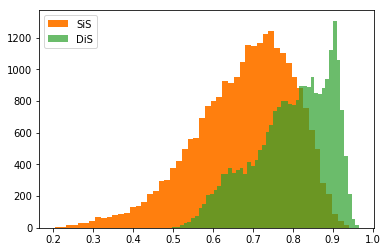

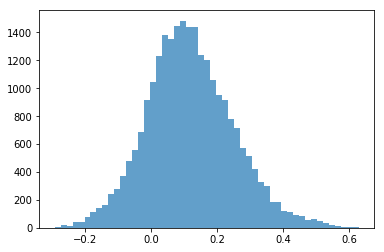

In [50]:
hist(fapS[:,1]/fapS[:,0],51,label='SiS',color = 'C1')
hist(fapS[:,2]/fapS[:,0],51,label='DiS',color = 'C2',alpha=0.7)
legend()
figure()
hist((fapS[:,2]-fapS[:,1])/fapS[:,0],51,alpha=0.7)

print(mean(fapS[:,1]/fapS[:,0]),mean(fapS[:,2]/fapS[:,0]))
print(mean((fapS[:,1]-fapS[:,2])/fapS[:,0]))

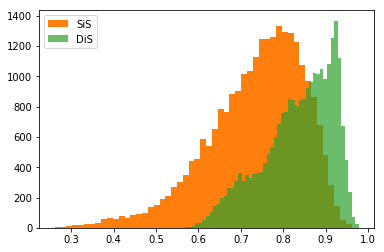

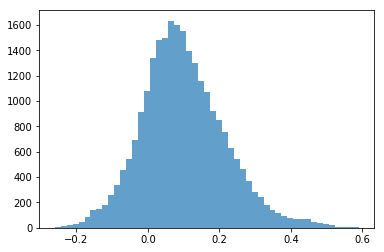

In [51]:
hist(fapD[:,1]/fapD[:,0],51,label='SiS',color = 'C1')
hist(fapD[:,2]/fapD[:,0],51,label='DiS',color = 'C2',alpha=0.7)
legend()
figure()
ht =hist((fapD[:,2]-fapD[:,1])/fapD[:,0],51,alpha=0.7)

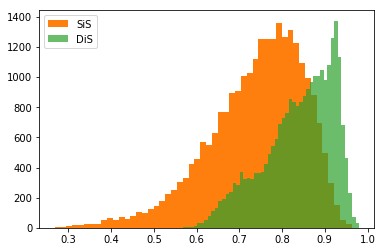

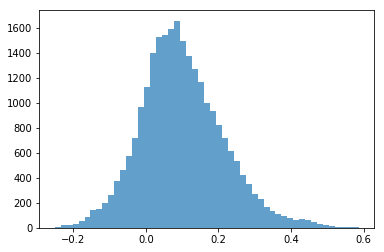

In [52]:
hist(fap0[:,1]/fap0[:,0],51,label='SiS',color = 'C1')
hist(fap0[:,2]/fap0[:,0],51,label='DiS',color = 'C2',alpha=0.7)
legend()
figure()
ht = hist((fap0[:,2]-fap0[:,1])/fap0[:,0],51,alpha=0.7)

In [53]:
with open("gatinginfo_0_cm1.pickle","wb") as f:
    pickle.dump([fapS,fapD,fap0,fapC],f)


In [54]:
fapS0,fapD0,fap00,fapC0 = fapS*1.0,fapD*1.0,fap0*1.0,fapC*1.0

In [55]:
nsp = 500

for i in range(50):
    vavg0,mes0,vtracs0,vtracsD0,vtracsS0,Ctracs0,me20,me30, trec,vtracs2,Ctracs2 = simulateSet(model,dis,sps,tG = -5,ton = 50,dton2 = 15,toffset = 100,t_stop = 500, EL = -70,btsr = ones(9)==1,VDCC = VDCCa, inh = 'in',silent = 'sp1')
    vavg0,mes0,vtracs0b,vtracsD0b,vtracsS0b,Ctracs0b,me20,me30, trec,vtracs2b,Ctracs2b = simulateSet(model,dis,sps,tG = 500,ton = 50,dton2 = 15,toffset = 100,t_stop = 500, EL = -70,btsr = ones(9)==1,VDCC = VDCCa, inh = 'in',silent = 'sp1')
    vavg0,mes0,vtracs0c,vtracsD0c,vtracsS0c,Ctracs0c,me20,me30, trec,vtracs2c,Ctracs2c = simulateSet(model,dis,sps,tG = -5,ton = 50,dton2 = 15,toffset = 100,t_stop = 500, EL = -70,btsr = ones(9)==1,VDCC = VDCCa, inh = 'out',silent = 'sp1')

    ap0 = getvpeaks(vtracs0b,vtracs0,vtracs0c, th = 0.5, plotose = False)
    apS = getvpeaks(vtracsS0b,vtracsS0,vtracsS0c, th = 0.02, plotose = False)
    apD = getvpeaks(vtracsD0b,vtracsD0,vtracsD0c, th = 0.02, plotose = False)
    apC = getvpeaks(Ctracs0b,Ctracs0,Ctracs0c, th = 0.00, plotose = False)
    
    if i == 0:
        fap0 = ap0+70
        fapS = apS+70
        fapD = apD+70
        fapC = apC
    else:
        fap0 = row_stack((fap0,ap0+70))
        fapS = row_stack((fapS,apS+70))
        fapD = row_stack((fapD,apD+70))
        fapC = row_stack((fapC,apC))
        
    dis = btset_cd(cd='DiS',size=nsp)
    sps = btset_cd(cd='Sp',size=nsp)

    iPSDsh = btShInh(size=500)

    if i%5 == 0: 
        print(i)
        with open("gatinginfo_u_temp_cm1.pickle","wb") as f:
            pickle.dump([fapS,fapD,fap0,fapC],f)


0
5
10
15
20
25
30
35
40
45


In [56]:
model.dend[1].L
model.dend[-1].L
dis['Dss'].max()

157.65932570124588

In [57]:
with open("gatinginfo_u_cm1.pickle","wb") as f:
    pickle.dump([fapS,fapD,fap0,fapC],f)

In [58]:
vavg0,mes0,vtracs0,vtracsD0,vtracsS0,Ctracs0,me20,me30, trec,vtracs2,Ctracs2 = simulateSet(model,dis,sps,tG = -5,ton = 50,dton2 = 15,toffset = 100,t_stop = 500, EL = -70,btsr = ones(9)==1,VDCC = VDCCa, inh = 'in',silent = 'sp1')
vavg0,mes0,vtracs0b,vtracsD0b,vtracsS0b,Ctracs0b,me20,me30, trec,vtracs2b,Ctracs2b = simulateSet(model,dis,sps,tG = 500,ton = 50,dton2 = 15,toffset = 100,t_stop = 500, EL = -70,btsr = ones(9)==1,VDCC = VDCCa, inh = 'in',silent = 'sp1')
vavg0,mes0,vtracs0c,vtracsD0c,vtracsS0c,Ctracs0c,me20,me30, trec,vtracs2c,Ctracs2c = simulateSet(model,dis,sps,tG = -5,ton = 50,dton2 = 15,toffset = 100,t_stop = 500, EL = -70,btsr = ones(9)==1,VDCC = VDCCa, inh = 'out',silent = 'sp1')

In [59]:
argmax(vtracs0b.max(axis=0)-vtracs0.max(axis=0))

416

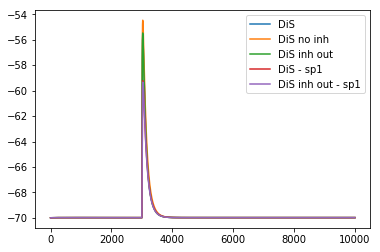

In [60]:
plot(vtracs0[:,342],label='DiS')
plot(vtracs0b[:,342],label='DiS no inh')
plot(vtracs0c[:,342],label='DiS inh out')
plot(vtracs2[:,342],label='DiS - sp1')
#plot(vtracs2b[:,342],label='DiS no inh- sp1')
plot(vtracs2c[:,342],label='DiS inh out - sp1')

legend()

(140, 200)

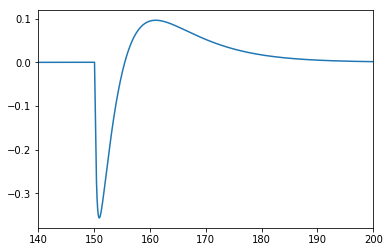

In [61]:
plot(arange(vtracs0.shape[0])*lb.h.dt,vtracs0[:,342]-vtracs0c[:,342])
xlim(140,200)

In [62]:
iPSDsh[342], dis['A2'][342], dis['Rneck'][342]

(0.07557631893486712, 0.05641388804000037, 90.1621292599992)

(array([ 2.,  2.,  1.,  0.,  1.,  1.,  3.,  6.,  5.,  9.,  9., 11., 18.,
        10., 20., 27., 35., 37., 48., 34., 24., 29., 22., 23., 25., 20.,
        15.,  8.,  6.,  7.,  5.,  8.,  8.,  6.,  3.,  1.,  4.,  1.,  2.,
         0.,  2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([-7.67921352, -7.24538652, -6.81155952, -6.37773251, -5.94390551,
        -5.51007851, -5.07625151, -4.6424245 , -4.2085975 , -3.7747705 ,
        -3.3409435 , -2.90711649, -2.47328949, -2.03946249, -1.60563548,
        -1.17180848, -0.73798148, -0.30415448,  0.12967253,  0.56349953,
         0.99732653,  1.43115354,  1.86498054,  2.29880754,  2.73263454,
         3.16646155,  3.60028855,  4.03411555,  4.46794256,  4.90176956,
         5.33559656,  5.76942356,  6.20325057,  6.63707757,  7.07090457,
         7.50473157,  7.93855858,  8.37238558,  8.80621258,  9.24003959,
         9.67386659, 10.10769359, 10.54152059, 10.9753476 , 11.4091746 ,
        11.8430016 , 12.27682861, 12.71065561, 13.1444

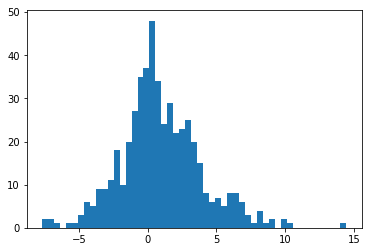

In [63]:
hist(vtracs0.max(axis=0)-vtracs0c.max(axis=0),51)

In [64]:
45/150

0.3

In [39]:
nsp = 500

for i in range(50):
    vavg0,mes0,vtracs0,vtracsD0,vtracsS0,Ctracs0,me20,me30, trec,vtracs2,Ctracs2 = simulateSet(model,dis,sps,tG = 10,ton = 50,dton2 = 15,toffset = 100,t_stop = 500, EL = -70,btsr = ones(9)==1,VDCC = VDCCa, inh = 'in',silent = 'sp0')
    vavg0,mes0,vtracs0b,vtracsD0b,vtracsS0b,Ctracs0b,me20,me30, trec,vtracs2b,Ctracs2b = simulateSet(model,dis,sps,tG = 500,ton = 50,dton2 = 15,toffset = 100,t_stop = 500, EL = -70,btsr = ones(9)==1,VDCC = VDCCa, inh = 'in',silent = 'sp0')
    vavg0,mes0,vtracs0c,vtracsD0c,vtracsS0c,Ctracs0c,me20,me30, trec,vtracs2c,Ctracs2c = simulateSet(model,dis,sps,tG = 10,ton = 50,dton2 = 15,toffset = 100,t_stop = 500, EL = -70,btsr = ones(9)==1,VDCC = VDCCa, inh = 'out',silent = 'sp0')

    ap0 = getvpeaks(vtracs2b,vtracs2,vtracs2c, th = 0.5, plotose = False)
    apS = getvpeaks(vtracsS0b,vtracsS0,vtracsS0c, th = 0.02, plotose = False)
    apD = getvpeaks(vtracsD0b,vtracsD0,vtracsD0c, th = 0.02, plotose = False)
    apC = getvpeaks(Ctracs0b,Ctracs0,Ctracs0c, th = 0., plotose = False)
    
 

    vavg0,mes0,vtracs0,vtracsD0,vtracsS0,Ctracs0,me20,me30, trec,vtracs2,Ctracs2 = simulateSet(model,dis,sps,tG = -5,ton = 50,dton2 = 15,toffset = 100,t_stop = 500, EL = -70,btsr = ones(9)==1,VDCC = VDCCa, inh = 'in',silent = 'sp1')
    vavg0,mes0,vtracs0b,vtracsD0b,vtracsS0b,Ctracs0b,me20,me30, trec,vtracs2b,Ctracs2b = simulateSet(model,dis,sps,tG = 500,ton = 50,dton2 = 15,toffset = 100,t_stop = 500, EL = -70,btsr = ones(9)==1,VDCC = VDCCa, inh = 'in',silent = 'sp1')
    vavg0,mes0,vtracs0c,vtracsD0c,vtracsS0c,Ctracs0c,me20,me30, trec,vtracs2c,Ctracs2c = simulateSet(model,dis,sps,tG = -5,ton = 50,dton2 = 15,toffset = 100,t_stop = 500, EL = -70,btsr = ones(9)==1,VDCC = VDCCa, inh = 'out',silent = 'sp1')

    bp0 = getvpeaks(vtracs0b,vtracs0,vtracs0c, th = 0.5, plotose = False)
    bpS = getvpeaks(vtracsS0b,vtracsS0,vtracsS0c, th = 0.02, plotose = False)
    bpD = getvpeaks(vtracsD0b,vtracsD0,vtracsD0c, th = 0.02, plotose = False)
    bpC = getvpeaks(Ctracs0b,Ctracs0,Ctracs0c, th = 0.00, plotose = False)
    
    ap0 = column_stack((ap0,bp0))
    apS = column_stack((apS,bpS))
    apD = column_stack((apD,bpD))
    apC = column_stack((apC,bpC))
    
    datat = column_stack((dis['A1'],dis['A2'],sis['A1'],iPSDsh,dis['Rneck'],sis['Rneck']))
    
    if i == 0:
        fap0 = ap0+70
        fapS = apS+70
        fapD = apD+70
        fapC = apC*1.0
        fdat = datat*1.0
    else:
        fap0 = row_stack((fap0,ap0+70))
        fapS = row_stack((fapS,apS+70))
        fapD = row_stack((fapD,apD+70))
        fapC = row_stack((fapC,apC))
        fdat = row_stack((fdat,datat))

    
    dis = btset_cd(cd='DiS',size=nsp)
    sps = btset_cd(cd='Sp',size=nsp)

    iPSDsh = btShInh(size=500)
    
    dendsizeL = max(max(dis['Dss'])+10,177)
    dendp1.L = dendsizeL-10
    dendp2.L = 8 
    dendsh.L = 2    
    
    if i%5 == 0: 
        print(i)
        with open("gatinginfo_f_temp_cm1.pickle","wb") as f:
            pickle.dump([fapS,fapD,fap0,fapC,fdat],f)


0
5
10


KeyboardInterrupt: 

In [ ]:
dendc.L

In [ ]:
max(max(dis['Dss'])+10,177)

In [40]:
with open("gatinginfo_f_cm1.pickle","wb") as f:
    pickle.dump([fapS,fapD,fap0,fapC,fdat],f)


In [69]:
lb.h.dt

0.05

In [70]:
iPSDsh = dis['A2']*1.0
